# Import libraries

In [1]:
import pandas as pd
import numpy as np

import unidecode
from bs4 import BeautifulSoup
import re
import contractions
import spacy

from keybert import KeyBERT
from keyphrase_vectorizers import KeyphraseCountVectorizer
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from transformers import pipeline

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.cm import ScalarMappable
%matplotlib inline

import gc
gc.enable()

import warnings
warnings.filterwarnings("ignore")
pd.set_option('max_columns',None)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# For dark mode
from jupyterthemes import jtplot
jtplot.style(theme='onedork', context='notebook', ticks=True, grid=True)

# Import data
Original data is much larger but for development and presentation reasons I am using only one book. When productionized, this process will be siloed for individual books anyway.

In [2]:
# Set input filepath
input_filepath = './input/'
filename = 'one_book.pkl'

df = pd.read_pickle(input_filepath + filename)
print(df.shape)
df.head()

(1540, 8)


,user_id,book_id,rating,summary,review_text,date,title,category
0,AF7X31XYRC21M,0316129089,5.0,Recommend 100% to all sci-fi readers,Have read all 6 books after viewing the first ...,2018-04-19,leviathan wakes,science fiction & fantasy
1,A1OL3QQXYHQEII,0316129089,5.0,Good Book,One of the best sci-fi books around. Good plo...,2018-04-18,leviathan wakes,science fiction & fantasy
2,AHUGIW3I35770,0316129089,4.0,Good Sci-fi...,"Is a human story with a sci-fi twist, as it sl...",2018-04-17,leviathan wakes,science fiction & fantasy
3,A14BAROCIAMNRK,0316129089,5.0,"Exciting,well written, and plausible science f...",It isn't often that a television show gets me ...,2018-04-17,leviathan wakes,science fiction & fantasy
4,A3060WHB3J9OCM,0316129089,4.0,Good space book,Feels like the author really wanted to combine...,2018-04-16,leviathan wakes,science fiction & fantasy


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1540 entries, 0 to 1539
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      1540 non-null   object        
 1   book_id      1540 non-null   object        
 2   rating       1540 non-null   float64       
 3   summary      1540 non-null   object        
 4   review_text  1539 non-null   object        
 5   date         1540 non-null   datetime64[ns]
 6   title        1540 non-null   object        
 7   category     1540 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 96.4+ KB


In [4]:
df.isnull().sum()

user_id        0
book_id        0
rating         0
summary        0
review_text    1
date           0
title          0
category       0
dtype: int64

In [5]:
df.dropna(subset=['review_text'], inplace=True)

# Data Pre-processing
+ remove urls
+ unicode normalization
+ remove html
+ remove emojis
+ lowercase
+ expand contractions
+ remove whitespace

#### Text cleaning functions

In [6]:
# unicode normalization
def clean_unicode(text):
    text = unidecode.unidecode(text)
    return text

# remove html
def remove_html(text):
    text = BeautifulSoup(text, "html.parser")
    return text.get_text()

# remove URLs
def remove_url(text):
    text = re.sub(r'http\S+', '', text)
    return text

# normalize contractions
def expand_contractions(text):
    text = contractions.fix(text)
    return text

# emojis
def remove_emojis(text):
    emoji_pattern = re.compile("["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)
    
    text = emoji_pattern.sub(r'', text)
    return text

# remove whitspace
def remove_whitespace(text):
    # remove whitespace at beginning and end of string
    text = re.sub("^\s+|\s+$", "", text, flags=re.UNICODE)
    # remove duplicate spaces
    text = " ".join(re.split("\s+", text, flags=re.UNICODE))
    # whitespace around punctuation
    text = re.sub(r'\s(?=[\.,:;])', "", text)
    return text

# convert back to string
def tokens_to_string(tokens):
    text = " ".join(tokens)
    return text

#### Clean reviews

In [7]:
%%time

nlp = spacy.load('en_core_web_lg')

reviews = df.review_text.tolist()

cleaned_sentences = []
original_review = []
for review in reviews:
    doc = nlp(review) # spacy object
    for sent in doc.sents:
        text = sent.text
        text = clean_unicode(text) # remove unicode
        text = remove_html(text) # remove html
        text = remove_url(text) # remove url
        text = remove_emojis(text) # remove emojis
        text = expand_contractions(text) # expand contractions
        text = remove_whitespace(text) # remove extra whitespace
        text = text.lower() # lowercase
        cleaned_sentences.append(text)
        original_review.append(doc.text)
        
# add to DF
df_ = pd.DataFrame({'review_text':original_review, 'cleaned_sentence':cleaned_sentences})
df3 = df_.merge(df, how='left', on='review_text')
df3

Wall time: 23 s


,review_text,cleaned_sentence,user_id,book_id,rating,summary,date,title,category
0,Have read all 6 books after viewing the first ...,have read all 6 books after viewing the first ...,AF7X31XYRC21M,0316129089,5.0,Recommend 100% to all sci-fi readers,2018-04-19,leviathan wakes,science fiction & fantasy
1,Have read all 6 books after viewing the first ...,they were excellent for filling in the backgro...,AF7X31XYRC21M,0316129089,5.0,Recommend 100% to all sci-fi readers,2018-04-19,leviathan wakes,science fiction & fantasy
2,Have read all 6 books after viewing the first ...,can wholeheartedly recommend them to all sci-f...,AF7X31XYRC21M,0316129089,5.0,Recommend 100% to all sci-fi readers,2018-04-19,leviathan wakes,science fiction & fantasy
3,One of the best sci-fi books around. Good plo...,one of the best sci-fi books around.,A1OL3QQXYHQEII,0316129089,5.0,Good Book,2018-04-18,leviathan wakes,science fiction & fantasy
4,One of the best sci-fi books around. Good plo...,good plot and believable tech makes this a gre...,A1OL3QQXYHQEII,0316129089,5.0,Good Book,2018-04-18,leviathan wakes,science fiction & fantasy
...,...,...,...,...,...,...,...,...,...
6897,I don't usually write reviews. This book dese...,he would be ejecting rounds unless the gun was...,A1AJDC30B7FKVB,0316129089,5.0,"Great detective story, set in the future and i...",2018-04-24,leviathan wakes,science fiction & fantasy
6898,Was happy to find out there was a book series ...,was happy to find out there was a book series ...,A3QATDHUASPFUU,0316129089,5.0,Excellent Pairing,2018-04-23,leviathan wakes,science fiction & fantasy
6899,Was happy to find out there was a book series ...,read this book in just a few days.,A3QATDHUASPFUU,0316129089,5.0,Excellent Pairing,2018-04-23,leviathan wakes,science fiction & fantasy
6900,Was happy to find out there was a book series ...,was very impressed with how faithful the tv se...,A3QATDHUASPFUU,0316129089,5.0,Excellent Pairing,2018-04-23,leviathan wakes,science fiction & fantasy


# Aspect extraction
+ KeyBERT utilizes BERT embeddings to produce keywords/phrases that best represent a document
+ KeyphraseVectorizer is an enhanced version of the CountVectorizer which is designed to find key phrases using part-of-speech patterns

#### Load key phrase extraction model

In [8]:
docs = df3.cleaned_sentence.tolist()
# pretrained model good for keyword/keyphrase extraction
kw_model = KeyBERT(model='distilbert-base-nli-mean-tokens')

#### Seed keywords
This list of words will be used to nudge the model to focus on these words if possible. These words are various aspects of writing and books in general which are content-agnostic metrics that can be used for all books.

In [9]:
## elements of writing (ideal topics) to nudge model towards (if possible)
seed_keywords = [
    'setting',
    'character',
    'plot',
    'conflict',
    'theme',
    'point of view',
    'tone',
    'style',
    'dialogue',
    'action',
    'description',
    'exposition',
    'motivation',
    'symbolism',
    'climax',
    'resolution',
    'imagery',
    'pacing',
    'writing',
    'author',
]

#### Extract key phrases based on part-of-speech patterns
This is a screenshot of the POS patterns because GitHub is not displaying them in the code for some reason.  
<img src="https://raw.githubusercontent.com/DarrellS0352/Combined-Guided-Topic-Modeling-Based-and-Aspect-Based-Sentiment-Analysis-For-Book-User-Reviews/main/img/pos%20patterns.PNG" align="left"/>

In [10]:
%%time

# POS pattern ideas (Banjar et al., 2020)
pos_patterns = [
    '<JJ.*><NN.*>+', # adjective > noun(s)
    '<RB.*><RB.*><NN.*>+', # adverb > adverb > noun(s)
    '<RB.*><JJ.*><NN.*>+', # adverb > adjective > noun(s)
    '<RB.*><VB.*><NN.*>+', # adverb > verb > noun(s)
    '<VB.*><NN.*>+', # verb > noun(s)
]

column_names = [
    'jj_nn',
    'rb_rb_nn',
    'rb_jj_nn',
    'rb_vb_nn',
    'vb_nn',
]

keyword_dict = {}
column_name_counter = 0
# run a key phrase extraction for each pos pattern
for pos_pattern in pos_patterns:
    vectorizer = KeyphraseCountVectorizer(
        pos_pattern=pos_pattern,
        stop_words='english'
    )
    keywords = kw_model.extract_keywords(
        docs, 
        vectorizer=vectorizer,
        use_mmr=True, # diversify results
        diversity=0.7, # diversify results
        seed_keywords=seed_keywords
    )
    # add to dict
    keyword_dict[column_names[column_name_counter]] = keywords
    # iterating through col names
    column_name_counter += 1

Wall time: 6min 12s


#### Wrangle key phrases
It is key to keep the length of all sublists equal

In [13]:
keyword_dict2 = {}
for key in keyword_dict.keys():
    pos_pattern_col = []
    for sublist in keyword_dict[key]:
        if sublist != []:
            pos_pattern_col.append([tup[0] for tup in sublist])
        else:
            pos_pattern_col.append(np.nan)
    keyword_dict2[key] = pos_pattern_col

#### Add key phrases to DataFrame

In [14]:
df4 = df3.copy()

for key in keyword_dict2.keys():
    df4[key] = keyword_dict2[key]
df4

,review_text,cleaned_sentence,user_id,book_id,rating,summary,date,title,category,jj_nn,rb_rb_nn,rb_jj_nn,rb_vb_nn,vb_nn
0,Have read all 6 books after viewing the first ...,have read all 6 books after viewing the first ...,AF7X31XYRC21M,0316129089,5.0,Recommend 100% to all sci-fi readers,2018-04-19,leviathan wakes,science fiction & fantasy,[first season],NaN,NaN,NaN,NaN
1,Have read all 6 books after viewing the first ...,they were excellent for filling in the backgro...,AF7X31XYRC21M,0316129089,5.0,Recommend 100% to all sci-fi readers,2018-04-19,leviathan wakes,science fiction & fantasy,NaN,NaN,NaN,NaN,NaN
2,Have read all 6 books after viewing the first ...,can wholeheartedly recommend them to all sci-f...,AF7X31XYRC21M,0316129089,5.0,Recommend 100% to all sci-fi readers,2018-04-19,leviathan wakes,science fiction & fantasy,NaN,NaN,NaN,NaN,[sci fi]
3,One of the best sci-fi books around. Good plo...,one of the best sci-fi books around.,A1OL3QQXYHQEII,0316129089,5.0,Good Book,2018-04-18,leviathan wakes,science fiction & fantasy,"[best sci fi books, best sci fi, best sci]",NaN,NaN,NaN,[sci fi]
4,One of the best sci-fi books around. Good plo...,good plot and believable tech makes this a gre...,A1OL3QQXYHQEII,0316129089,5.0,Good Book,2018-04-18,leviathan wakes,science fiction & fantasy,"[gritty novel, good plot, believable tech]",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6897,I don't usually write reviews. This book dese...,he would be ejecting rounds unless the gun was...,A1AJDC30B7FKVB,0316129089,5.0,"Great detective story, set in the future and i...",2018-04-24,leviathan wakes,science fiction & fantasy,NaN,NaN,NaN,NaN,[ejecting rounds]
6898,Was happy to find out there was a book series ...,was happy to find out there was a book series ...,A3QATDHUASPFUU,0316129089,5.0,Excellent Pairing,2018-04-23,leviathan wakes,science fiction & fantasy,NaN,NaN,NaN,NaN,NaN
6899,Was happy to find out there was a book series ...,read this book in just a few days.,A3QATDHUASPFUU,0316129089,5.0,Excellent Pairing,2018-04-23,leviathan wakes,science fiction & fantasy,[few days],NaN,NaN,NaN,NaN
6900,Was happy to find out there was a book series ...,was very impressed with how faithful the tv se...,A3QATDHUASPFUU,0316129089,5.0,Excellent Pairing,2018-04-23,leviathan wakes,science fiction & fantasy,NaN,NaN,NaN,NaN,NaN


#### Re-format list values to string values

In [15]:
for key in keyword_dict2.keys():
    df4 = df4.explode(key)
df4

,review_text,cleaned_sentence,user_id,book_id,rating,summary,date,title,category,jj_nn,rb_rb_nn,rb_jj_nn,rb_vb_nn,vb_nn
0,Have read all 6 books after viewing the first ...,have read all 6 books after viewing the first ...,AF7X31XYRC21M,0316129089,5.0,Recommend 100% to all sci-fi readers,2018-04-19,leviathan wakes,science fiction & fantasy,first season,NaN,NaN,NaN,NaN
1,Have read all 6 books after viewing the first ...,they were excellent for filling in the backgro...,AF7X31XYRC21M,0316129089,5.0,Recommend 100% to all sci-fi readers,2018-04-19,leviathan wakes,science fiction & fantasy,NaN,NaN,NaN,NaN,NaN
2,Have read all 6 books after viewing the first ...,can wholeheartedly recommend them to all sci-f...,AF7X31XYRC21M,0316129089,5.0,Recommend 100% to all sci-fi readers,2018-04-19,leviathan wakes,science fiction & fantasy,NaN,NaN,NaN,NaN,sci fi
3,One of the best sci-fi books around. Good plo...,one of the best sci-fi books around.,A1OL3QQXYHQEII,0316129089,5.0,Good Book,2018-04-18,leviathan wakes,science fiction & fantasy,best sci fi books,NaN,NaN,NaN,sci fi
3,One of the best sci-fi books around. Good plo...,one of the best sci-fi books around.,A1OL3QQXYHQEII,0316129089,5.0,Good Book,2018-04-18,leviathan wakes,science fiction & fantasy,best sci fi,NaN,NaN,NaN,sci fi
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6897,I don't usually write reviews. This book dese...,he would be ejecting rounds unless the gun was...,A1AJDC30B7FKVB,0316129089,5.0,"Great detective story, set in the future and i...",2018-04-24,leviathan wakes,science fiction & fantasy,NaN,NaN,NaN,NaN,ejecting rounds
6898,Was happy to find out there was a book series ...,was happy to find out there was a book series ...,A3QATDHUASPFUU,0316129089,5.0,Excellent Pairing,2018-04-23,leviathan wakes,science fiction & fantasy,NaN,NaN,NaN,NaN,NaN
6899,Was happy to find out there was a book series ...,read this book in just a few days.,A3QATDHUASPFUU,0316129089,5.0,Excellent Pairing,2018-04-23,leviathan wakes,science fiction & fantasy,few days,NaN,NaN,NaN,NaN
6900,Was happy to find out there was a book series ...,was very impressed with how faithful the tv se...,A3QATDHUASPFUU,0316129089,5.0,Excellent Pairing,2018-04-23,leviathan wakes,science fiction & fantasy,NaN,NaN,NaN,NaN,NaN


In [16]:
# drop any row/sentence that had no pos pattern values (All NaNs in jj_nn, rb_rb_nn... etc)
df4.dropna(subset=list(keyword_dict2.keys()), how='all', inplace=True)

#### Separate key phrase descriptive words and noun words
It is possible to slice the key phrases accurately based off the POS pattern.  
Example: jj_nn will always be in the form of single adjective > noun(s) so the descriptive word will always be index 0 and the noun(s) index 1+.

In [17]:
for key in keyword_dict2.keys():
    descs = []
    nouns = []
    if key in ['jj_nn','vb_nn']:
        for keyphrase in df4[key]:
            if keyphrase is not np.nan:
                desc = keyphrase.split()[0]
                noun = ' '.join(keyphrase.split()[1:])
                descs.append(desc)
                nouns.append(noun)
            else:
                descs.append(np.nan)
                nouns.append(np.nan)
    elif key in ['rb_rb_nn','rb_jj_nn','rb_vb_nn']:
        for keyphrase in df4[key]:
            if keyphrase is not np.nan:
                desc = ' '.join(keyphrase.split()[:2])
                noun = ' '.join(keyphrase.split()[2:])
                descs.append(desc)
                nouns.append(noun)
            else:
                descs.append(np.nan)
                nouns.append(np.nan)
                
    df4[key + '_desc'] = descs
    df4[key + '_noun'] = nouns
    
df4.head()

,review_text,cleaned_sentence,user_id,book_id,rating,summary,date,title,category,jj_nn,rb_rb_nn,rb_jj_nn,rb_vb_nn,vb_nn,jj_nn_desc,jj_nn_noun,rb_rb_nn_desc,rb_rb_nn_noun,rb_jj_nn_desc,rb_jj_nn_noun,rb_vb_nn_desc,rb_vb_nn_noun,vb_nn_desc,vb_nn_noun
0,Have read all 6 books after viewing the first ...,have read all 6 books after viewing the first ...,AF7X31XYRC21M,0316129089,5.0,Recommend 100% to all sci-fi readers,2018-04-19,leviathan wakes,science fiction & fantasy,first season,NaN,NaN,NaN,NaN,first,season,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Have read all 6 books after viewing the first ...,can wholeheartedly recommend them to all sci-f...,AF7X31XYRC21M,0316129089,5.0,Recommend 100% to all sci-fi readers,2018-04-19,leviathan wakes,science fiction & fantasy,NaN,NaN,NaN,NaN,sci fi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sci,fi
3,One of the best sci-fi books around. Good plo...,one of the best sci-fi books around.,A1OL3QQXYHQEII,0316129089,5.0,Good Book,2018-04-18,leviathan wakes,science fiction & fantasy,best sci fi books,NaN,NaN,NaN,sci fi,best,sci fi books,NaN,NaN,NaN,NaN,NaN,NaN,sci,fi
3,One of the best sci-fi books around. Good plo...,one of the best sci-fi books around.,A1OL3QQXYHQEII,0316129089,5.0,Good Book,2018-04-18,leviathan wakes,science fiction & fantasy,best sci fi,NaN,NaN,NaN,sci fi,best,sci fi,NaN,NaN,NaN,NaN,NaN,NaN,sci,fi
3,One of the best sci-fi books around. Good plo...,one of the best sci-fi books around.,A1OL3QQXYHQEII,0316129089,5.0,Good Book,2018-04-18,leviathan wakes,science fiction & fantasy,best sci,NaN,NaN,NaN,sci fi,best,sci,NaN,NaN,NaN,NaN,NaN,NaN,sci,fi


In [18]:
# static/non-keyphrase/non-pos pattern columns
id_vars = [
    'review_text',
    'cleaned_sentence',
    'user_id',
    'book_id',
    'rating',
    'summary',
    'date',
    'title',
    'category',
]

# iterate through keyphrase/pos_pattern columns and consolidate into keyphrase/desc/noun columns in new dataframe
dfs = []
for key in keyword_dict2.keys():
    desc_col = key + '_desc'
    noun_col = key + '_noun'
    df_ = (
        df4[id_vars + [key, desc_col, noun_col]]
        .rename(columns={key:'keyphrase', desc_col:'desc', noun_col:'noun'})
    )
    dfs.append(df_)
    
df5 = (
    pd.concat(dfs, ignore_index=True)
    .dropna(subset=['desc','noun'])
    .drop_duplicates(subset=['cleaned_sentence','desc','noun'])
    .reset_index(drop=True)
)
df5

,review_text,cleaned_sentence,user_id,book_id,rating,summary,date,title,category,keyphrase,desc,noun
0,Have read all 6 books after viewing the first ...,have read all 6 books after viewing the first ...,AF7X31XYRC21M,0316129089,5.0,Recommend 100% to all sci-fi readers,2018-04-19,leviathan wakes,science fiction & fantasy,first season,first,season
1,One of the best sci-fi books around. Good plo...,one of the best sci-fi books around.,A1OL3QQXYHQEII,0316129089,5.0,Good Book,2018-04-18,leviathan wakes,science fiction & fantasy,best sci fi books,best,sci fi books
2,One of the best sci-fi books around. Good plo...,one of the best sci-fi books around.,A1OL3QQXYHQEII,0316129089,5.0,Good Book,2018-04-18,leviathan wakes,science fiction & fantasy,best sci fi,best,sci fi
3,One of the best sci-fi books around. Good plo...,one of the best sci-fi books around.,A1OL3QQXYHQEII,0316129089,5.0,Good Book,2018-04-18,leviathan wakes,science fiction & fantasy,best sci,best,sci
4,One of the best sci-fi books around. Good plo...,good plot and believable tech makes this a gre...,A1OL3QQXYHQEII,0316129089,5.0,Good Book,2018-04-18,leviathan wakes,science fiction & fantasy,gritty novel,gritty,novel
...,...,...,...,...,...,...,...,...,...,...,...,...
8037,It's so good you don't realize time is passing...,it is so good you do not realize time is passi...,A36GNTONCY1F6M,0316129089,5.0,Great book,2018-04-27,leviathan wakes,science fiction & fantasy,realize time,realize,time
8038,I don't usually write reviews. This book dese...,i do not usually write reviews.,A1AJDC30B7FKVB,0316129089,5.0,"Great detective story, set in the future and i...",2018-04-24,leviathan wakes,science fiction & fantasy,write reviews,write,reviews
8039,I don't usually write reviews. This book dese...,this book deserved the effort to at least put ...,A1AJDC30B7FKVB,0316129089,5.0,"Great detective story, set in the future and i...",2018-04-24,leviathan wakes,science fiction & fantasy,put something,put,something
8040,I don't usually write reviews. This book dese...,i am a police detective and i felt miller's ch...,A1AJDC30B7FKVB,0316129089,5.0,"Great detective story, set in the future and i...",2018-04-24,leviathan wakes,science fiction & fantasy,felt miller,felt,miller


# Guided topic modeling
+ Seed word guided BERTopic model
+ Stopwords were not removed prior to this because they contribute to the context for transformer-based embedding models.
  + CountVectorizer removes stopwords for you
+ The diversity hyperparameter diversifies the words used for each topic reducing overlap
+ Pre-trained SentenceTransformer model 'all-MiniLM-L6-v2' has history of good out-of-the-box performance
  + Helps when training your own model is infeasible
+ N-grams are automatically considered based off the specified range

In [19]:
docs_to_use = df5.cleaned_sentence.unique().tolist() # docs or raw_docs

sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = sentence_model.encode(docs_to_use, show_progress_bar=False)

vectorizer_model = CountVectorizer(stop_words="english") # removing stop words

diversity = 0.7 # diversify topic representation

topic_model = BERTopic(
    embedding_model=sentence_model,
    vectorizer_model=vectorizer_model,
    diversity=diversity, # diversify topic representation
    n_gram_range=(1,3), # n_grams from N to N
    nr_topics='auto', # automatically select number of topics
    seed_topic_list=seed_keywords # guided topic modeling
)
topics, probs = topic_model.fit_transform(docs_to_use, embeddings)

In [20]:
# consolidating in dataframe
topic_df = pd.DataFrame({'cleaned_sentence':docs_to_use, 'topic_n':topic_model.topics_})
topic_df['topic'] = topic_df.topic_n.map(topic_model.topic_labels_)

topic_df['topic_freq'] = topic_df.topic_n.apply(lambda x: topic_model.get_topic_freq(x))
topic_df = topic_df.loc[topic_df.topic_n != -1] # -1's are outliers from topic model and should be ignored
topic_df

,cleaned_sentence,topic_n,topic,topic_freq
0,have read all 6 books after viewing the first ...,5,5_expanse_syfy_channel_based,79
1,one of the best sci-fi books around.,0,0_series_read_books_syfy,1350
4,like the parallels of a future society with ou...,11,11_future_humanity_interesting_building,35
5,it is not often that a television show gets me...,5,5_expanse_syfy_channel_based,79
10,the two main male characters are decently writ...,0,0_series_read_books_syfy,1350
...,...,...,...,...
4097,the reviews are at least partly true: it is a ...,1,1_operas_read_fashioned_solar,198
4098,how come novels this fun are so hard to find n...,0,0_series_read_books_syfy,1350
4099,the book also suffers from being badly edited ...,0,0_series_read_books_syfy,1350
4101,this book deserved the effort to at least put ...,16,16_3am_chores_chapters_turning,26


# Sentiment analysis

#### Load pre-trained sentiment model

In [21]:
# https://huggingface.co/siebert/sentiment-roberta-large-english?text=I+like+you.+I+love+you
model = 'siebert/sentiment-roberta-large-english'
sentiment_pipeline = pipeline("sentiment-analysis", model=model)

### Aspect-based sentiment analysis
+ Produces sentiments of aspects that are buried within sentences
  + Most sentiment analyses produce a sentiment for the entire review
+ Allows you to determine sentiment about specific nouns within sentences
  + In this case it is sentiment of elements of writing and books

In [24]:
%%time
docs = df5.keyphrase.tolist()
# sentiment model
sents = sentiment_pipeline(docs)

# get sentiment label (POSITIVE/NEGATIVE) and sentiment score for each keyphrase
labels = []
scores = []
for sent_dict in sents:
    labels.append(sent_dict['label'])
    scores.append(sent_dict['score'])
    
df5['sent_label'] = labels
df5['sent_score'] = scores

# changing negative sentiments to negative values in order to aggregate with positive sentiments
df5.sent_score[df5.sent_label == 'NEGATIVE'] *= -1

# lemmatizing nouns
lemma_dict = {}
unique_nouns = df5.noun.unique().tolist()
for noun in unique_nouns:
    doc = nlp(noun)
    for token in doc:
        lemma = token.lemma_
        lemma_dict[noun] = lemma
df5['aspect'] = df5.noun.map(lemma_dict)

df5.head()

Wall time: 13min 1s


,review_text,cleaned_sentence,user_id,book_id,rating,summary,date,title,category,keyphrase,desc,noun,sent_label,sent_score,aspect
0,Have read all 6 books after viewing the first ...,have read all 6 books after viewing the first ...,AF7X31XYRC21M,0316129089,5.0,Recommend 100% to all sci-fi readers,2018-04-19,leviathan wakes,science fiction & fantasy,first season,first,season,POSITIVE,0.997024,season
1,One of the best sci-fi books around. Good plo...,one of the best sci-fi books around.,A1OL3QQXYHQEII,0316129089,5.0,Good Book,2018-04-18,leviathan wakes,science fiction & fantasy,best sci fi books,best,sci fi books,POSITIVE,0.997981,book
2,One of the best sci-fi books around. Good plo...,one of the best sci-fi books around.,A1OL3QQXYHQEII,0316129089,5.0,Good Book,2018-04-18,leviathan wakes,science fiction & fantasy,best sci fi,best,sci fi,POSITIVE,0.997966,fi
3,One of the best sci-fi books around. Good plo...,one of the best sci-fi books around.,A1OL3QQXYHQEII,0316129089,5.0,Good Book,2018-04-18,leviathan wakes,science fiction & fantasy,best sci,best,sci,POSITIVE,0.997982,sci
4,One of the best sci-fi books around. Good plo...,good plot and believable tech makes this a gre...,A1OL3QQXYHQEII,0316129089,5.0,Good Book,2018-04-18,leviathan wakes,science fiction & fantasy,gritty novel,gritty,novel,POSITIVE,0.985310,novel


In [90]:
# drop semi-duplicate rows produced by different pos-patterns
# ex: keyphrase1 = best sci fi books keyphrase2 = best sci fi
drop_idxs = []
for idx in range(len(df5)):
    keyphrase = df5.keyphrase.iloc[idx]
    previous_keyphrase = df5.keyphrase.iloc[idx-1]
    if keyphrase in previous_keyphrase:
        drop_idxs.append(idx)
        
df5 = df5.loc[~df5.index.isin(drop_idxs)].reset_index(drop=True)
df5

,review_text,cleaned_sentence,user_id,book_id,rating,summary,date,title,category,keyphrase,desc,noun,sent_label,sent_score,aspect
0,Have read all 6 books after viewing the first ...,have read all 6 books after viewing the first ...,AF7X31XYRC21M,0316129089,5.0,Recommend 100% to all sci-fi readers,2018-04-19,leviathan wakes,science fiction & fantasy,first season,first,season,POSITIVE,0.997024,season
1,One of the best sci-fi books around. Good plo...,one of the best sci-fi books around.,A1OL3QQXYHQEII,0316129089,5.0,Good Book,2018-04-18,leviathan wakes,science fiction & fantasy,best sci fi books,best,sci fi books,POSITIVE,0.997981,book
2,One of the best sci-fi books around. Good plo...,good plot and believable tech makes this a gre...,A1OL3QQXYHQEII,0316129089,5.0,Good Book,2018-04-18,leviathan wakes,science fiction & fantasy,gritty novel,gritty,novel,POSITIVE,0.985310,novel
3,One of the best sci-fi books around. Good plo...,good plot and believable tech makes this a gre...,A1OL3QQXYHQEII,0316129089,5.0,Good Book,2018-04-18,leviathan wakes,science fiction & fantasy,good plot,good,plot,POSITIVE,0.998720,plot
4,One of the best sci-fi books around. Good plo...,good plot and believable tech makes this a gre...,A1OL3QQXYHQEII,0316129089,5.0,Good Book,2018-04-18,leviathan wakes,science fiction & fantasy,believable tech,believable,tech,POSITIVE,0.997849,tech
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7630,It's so good you don't realize time is passing...,it is so good you do not realize time is passi...,A36GNTONCY1F6M,0316129089,5.0,Great book,2018-04-27,leviathan wakes,science fiction & fantasy,realize time,realize,time,POSITIVE,0.984091,time
7631,I don't usually write reviews. This book dese...,i do not usually write reviews.,A1AJDC30B7FKVB,0316129089,5.0,"Great detective story, set in the future and i...",2018-04-24,leviathan wakes,science fiction & fantasy,write reviews,write,reviews,POSITIVE,0.985221,review
7632,I don't usually write reviews. This book dese...,this book deserved the effort to at least put ...,A1AJDC30B7FKVB,0316129089,5.0,"Great detective story, set in the future and i...",2018-04-24,leviathan wakes,science fiction & fantasy,put something,put,something,NEGATIVE,-0.992833,something
7633,I don't usually write reviews. This book dese...,i am a police detective and i felt miller's ch...,A1AJDC30B7FKVB,0316129089,5.0,"Great detective story, set in the future and i...",2018-04-24,leviathan wakes,science fiction & fantasy,felt miller,felt,miller,POSITIVE,0.965340,miller


#### Reduce to seed keyword aspects only and aggregate sentiments for each aspect

In [91]:
seed_keyword_df = df5.loc[df5.aspect.isin(seed_keywords)]

seed_keyword_sents = (
    seed_keyword_df
    .groupby(['aspect'], as_index=False)
    .agg(
        sent_score_sum=('sent_score','sum'),
        sent_score_mean=('sent_score','mean'),
        keyphrase_count=('aspect','count')
    )
    .sort_values(by='keyphrase_count', ascending=False)
    .assign(
        pct_total = lambda df_: df_.keyphrase_count / df_.keyphrase_count.sum(),
        running_pct_total = lambda df_: df_.pct_total.cumsum()
    )
)
seed_keyword_sents

,aspect,sent_score_sum,sent_score_mean,keyphrase_count,pct_total,running_pct_total
2,character,232.852158,0.665292,350,0.558214,0.558214
10,plot,47.900931,0.509584,94,0.149920,0.708134
0,action,22.968439,0.620769,37,0.059011,0.767145
1,author,25.727520,0.803985,32,0.051037,0.818182
13,style,26.667558,0.919571,29,0.046252,0.864434
14,theme,9.905203,0.550289,18,0.028708,0.893142
4,conflict,-4.096526,-0.292609,14,0.022329,0.915470
6,dialogue,6.674342,0.606758,11,0.017544,0.933014
9,pacing,9.987781,0.998778,10,0.015949,0.948963
5,description,-0.760896,-0.084544,9,0.014354,0.963317


#### Plot aspect-based sentiments
+ Color indicates mean sentiment (-1/red most negative, 1/blue most positive)
+ X-axis represents the number of aspect occurences in the user reviews of the specified book
+ This is a simple method to determine how important a given aspect sentiment is (three people may like the climax but it is only three opinions)

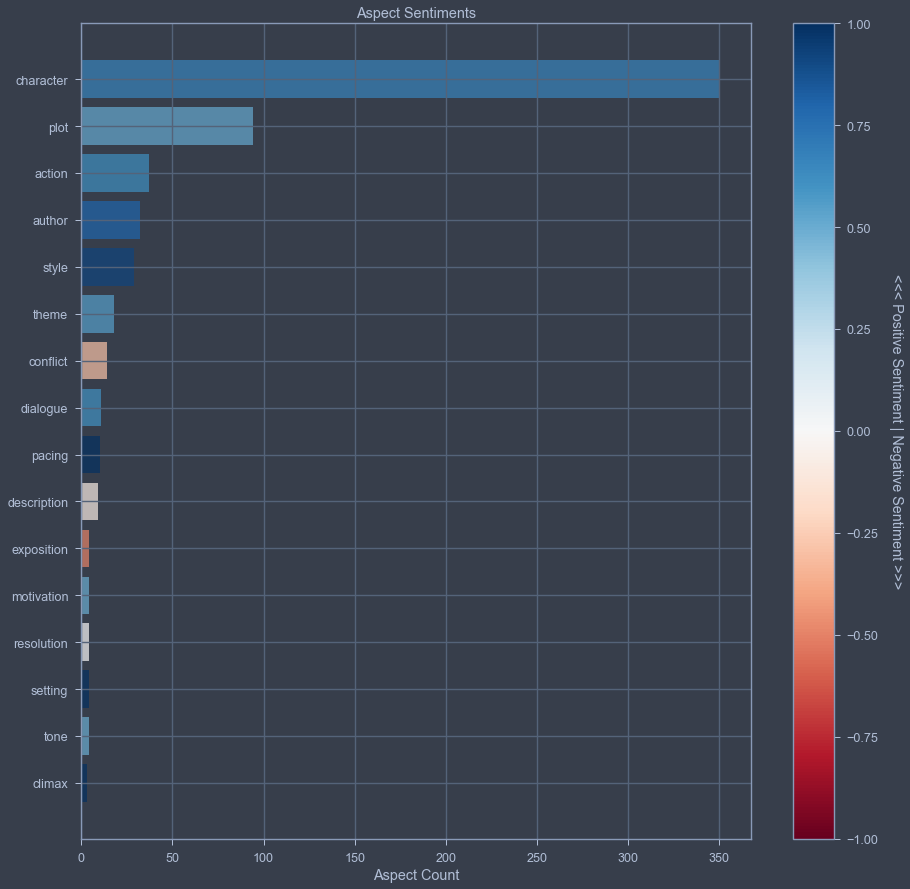

In [92]:
cmap = mpl.cm.RdBu

plt.figure(figsize=(15,15))
norm = plt.Normalize(-1, 1)

# plot
plt.barh(
    seed_keyword_sents.aspect,
    seed_keyword_sents.keyphrase_count,
    color=cmap(norm(seed_keyword_sents.sent_score_mean.values)),
    alpha=0.7
)

plt.xlabel('Aspect Count')
plt.gca().invert_yaxis()
plt.title('Aspect Sentiments')

# colorbar
sm = ScalarMappable(
    cmap=cmap,
    norm=plt.Normalize(-1, 1)
)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('<<< Positive Sentiment | Negative Sentiment >>>', rotation=270, labelpad=25)

plt.show()

## Guided topic modeling based sentiment analysis
+ Provides meta and content focused sentiments
  + Can possibly have some topics similar to the previously shown aspects, but also produces content-focused topics
  + For example: 
    + The topic 'fi_recommended_asimov_readable' gives the impression the book is comparable to Isaac Asimov novels
    + While the topic 'corey_ty_pen_sa' won't make sense unless you know they are talking about the co-authors combined pen name (James S.A. Corey)

In [93]:
%%time
docs = topic_df.cleaned_sentence.tolist()
# sentiment model
sents = sentiment_pipeline(docs)

# get sentiment label (POSITIVE/NEGATIVE) and sentiment score for each keyphrase
labels = []
scores = []
for sent_dict in sents:
    labels.append(sent_dict['label'])
    scores.append(sent_dict['score'])
    
topic_df['sent_label'] = labels
topic_df['sent_score'] = scores

# reversing negative sentiments to negative values in order to aggregate with positive sentiments
topic_df.sent_score[topic_df.sent_label == 'NEGATIVE'] *= -1
# remove prefix topic numbers from topics
topic_df['topic'] = topic_df.topic.apply(lambda x: x.lstrip('0123456789._ '))
topic_df.head()

Wall time: 5min 32s


,cleaned_sentence,topic_n,topic,topic_freq,sent_label,sent_score
0,have read all 6 books after viewing the first ...,5,expanse_syfy_channel_based,79,POSITIVE,0.998440
1,one of the best sci-fi books around.,0,series_read_books_syfy,1350,POSITIVE,0.998820
4,like the parallels of a future society with ou...,11,future_humanity_interesting_building,35,POSITIVE,0.997811
5,it is not often that a television show gets me...,5,expanse_syfy_channel_based,79,POSITIVE,0.998721
10,the two main male characters are decently writ...,0,series_read_books_syfy,1350,POSITIVE,0.994455


#### Aggregate sentiments for each topic

In [94]:
topic_sents = (
    topic_df
    .groupby(['topic'], as_index=False)
    .agg(
        sent_score_sum=('sent_score','sum'),
        sent_score_mean=('sent_score','mean'),
        topic_count=('topic','count')
    )
    .sort_values(by='topic_count', ascending=False)
    .assign(
        pct_total = lambda df_: df_.topic_count / df_.topic_count.sum(),
        running_pct_total = lambda df_: df_.pct_total.cumsum()
    )
)
topic_sents

,topic,sent_score_sum,sent_score_mean,topic_count,pct_total,running_pct_total
17,series_read_books_syfy,907.080900,0.671912,1350,0.538063,0.538063
13,operas_read_fashioned_solar,142.564510,0.720023,198,0.078916,0.616979
12,leviathan_wakes_future_corey,63.054697,0.558006,113,0.045038,0.662017
10,holden_detective_characters_ship,32.467185,0.312184,104,0.041451,0.703468
6,corey_pen_ty_sa,60.922998,0.716741,85,0.033878,0.737346
8,expanse_syfy_channel_based,68.845975,0.871468,79,0.031487,0.768832
18,setting_themes_factions_socio,35.364089,0.561335,63,0.025110,0.793942
22,treat_cw_gripe_melbourne,56.885252,0.997987,57,0.022718,0.816660
16,physics_artificial_spin_floor,18.980683,0.372170,51,0.020327,0.836987
2,book_week_hopefully_purchased,37.962550,0.759251,50,0.019928,0.856915


#### Plot guided topic modeling based sentiments
+ Color indicates mean sentiment (-1/red most negative, 1/blue most positive)
+ X-axis represents the number of topic occurences

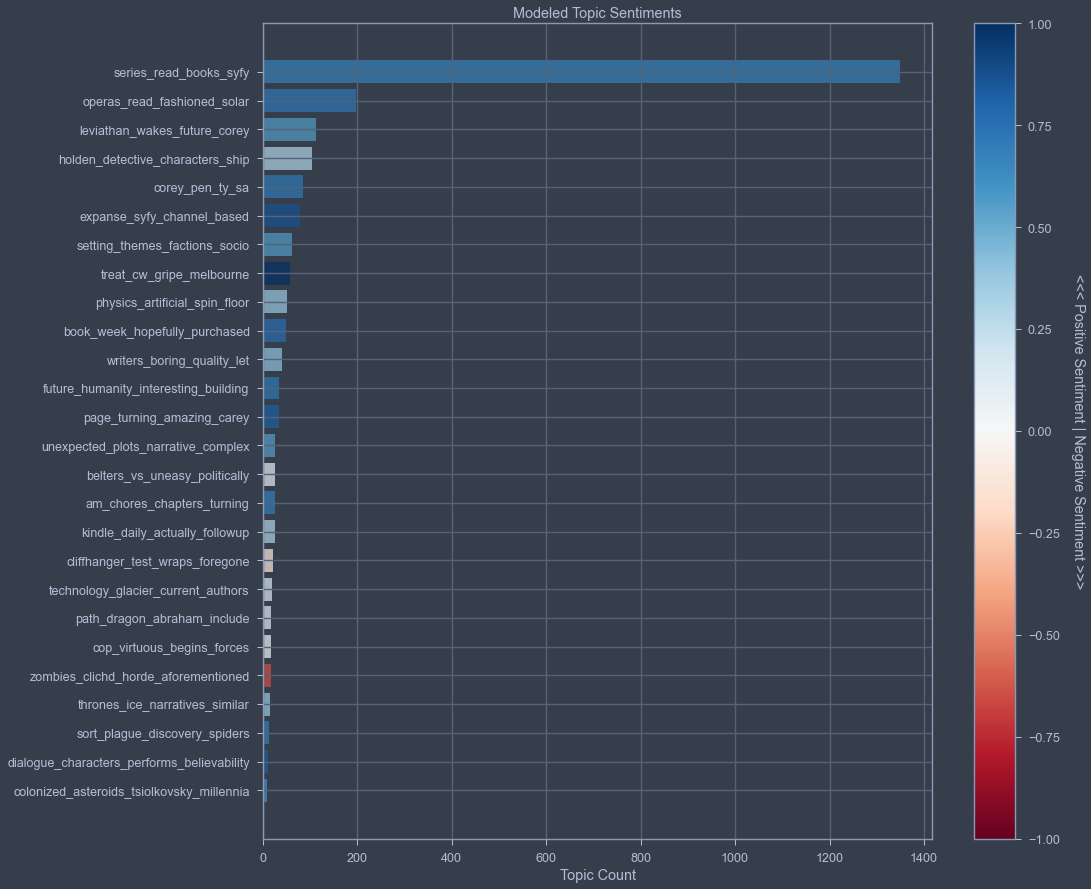

In [95]:
cmap = mpl.cm.RdBu

plt.figure(figsize=(15,15))
norm = plt.Normalize(-1, 1)

# plot
plt.barh(
    topic_sents.topic,
    topic_sents.topic_count,
    color=cmap(norm(topic_sents.sent_score_mean.values)),
    alpha=0.7
)
plt.xlabel('Topic Count')
plt.gca().invert_yaxis()
plt.title('Modeled Topic Sentiments')

# colorbar
sm = ScalarMappable(
    cmap=cmap,
    norm=plt.Normalize(-1, 1)
)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('<<< Positive Sentiment | Negative Sentiment >>>', rotation=270, labelpad=25)

plt.show()